In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from torchsummary import summary
from torchvision.utils import save_image
import torchvision

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [15]:
class cDCGAN(object):
    
    '''
    Conditional DCGAN class.
    '''
    
    def _checkDirectory(self, dirName):
        
        if not os.path.exists(dirName):
            print(f"{dirName} directory does not exist. Making {dirName}")
            os.makedirs(dirName)
            
        else: print(f"{dirName} directory exists.")
    
    
    def __init__(self, dataloader, classes, save_dir, num_epochs,
                 criterion, netD, netG, optimizerD, optimizerG, device):
        
        # data parameters
        self.dataloader = dataloader
        self.classes = classes # class labels
        self.n_classes = len(classes) # number of classes
        
        # save file locations
        self._checkDirectory(save_dir) # check whether save dir exists
        self.checkpoint_dir = os.path.join(save_dir, 'checkpoints')
        self._checkDirectory(self.checkpoint_dir) # create checkpoints dir
        self.fake_image_dir = os.path.join(save_dir, 'fake_images')
        self._checkDirectory(self.fake_image_dir) # create fake images dir
        
        # model parameters
        self.num_epochs = num_epochs # number of epochs to train for
        self.start_epoch = 1 # the starting epoch
        self.criterion = criterion # loss function
        self.real_label = 1 # Establish convention for real and fake labels during training
        self.fake_label = 0

        # networks init
        self.netD = netD
        self.netG = netG
        self.optimizerD = optimizerD
        self.optimizerG = optimizerG
        
        # device
        self.device = device # specify device being used
        
        # Create fixed noise to visualize the progression of the generator
        self.fixed_noise = torch.randn(64, nz, device=self.device) # torch.Size([64, 100])
            
        
    def generate_fake_images(self, class_index_tensor, noise, image_name = 'random',
                             save = True, ncols = 8):
        
        '''
        Generate a batch of fake images using current generator weights.
        
        Inputs
        
            class_index_tensor (LongTensor)
                The class index to create fake images for. The number of fake images generated is equal
                to the length of the tensor. So a tensor filled with 10 "1"s will generate 10 images for
                the class that corresponds to "1".
                
            noise (Tensor)
                Random noise that will be put through the generator weights to produce an image.
        
            image_name (STR)
                Image name for the saved file.
                If running this function in model training, image_name should contain a changing variable,
                otherwise the files will just keep overwriting each other with the same name.
                Default: 'random' (in case save = True but no image_name provided)
            
            save (BOOL)
                If save is TRUE, the image file will be saved in the specified "self.fake_image_dir".
                Otherwise, just return the image data for plotting.
                Default: TRUE
            
        ''' 
        with torch.no_grad():
            # create fake images for a the labels in class_index_tensor
            fake = self.netG(noise, class_index_tensor).detach().cpu()
        
        if save: # save images in the fake_image_dir
            save_image(fake.data, f'{self.fake_image_dir}/{image_name}.png',
                       nrow=ncols, padding=2, normalize=True)
        
        return fake.data
    

    def train(self):
        
        '''
        Training loop
        '''
        if self.num_epochs == 0:
            print(f"No epochs set for training. Exiting training loop.")
            return
            
        # Lists to keep track of progress
        self.G_losses = [] # generator loss
        self.D_losses = [] # discriminator loss
        iters = 0

        print("Starting Training Loop...")
        # For each epoch
        for epoch in range(self.start_epoch, self.start_epoch + self.num_epochs):
            # For each batch in the dataloader
            for i, (imgs, class_labels) in enumerate(self.dataloader):

                ############################
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                ###########################

                ## Train with all-real batch
                ###########################
                self.netD.zero_grad()

                # Format batch
                real_imgs = imgs.to(self.device)
                b_size = real_imgs.size(0)

                # Set ground truth labels as REAL
                validity_label = torch.full((b_size,), self.real_label, device=device)

                # Forward pass real batch through D
                output = self.netD(real_imgs, class_labels).view(-1)

                # Calculate loss on all-real batch
                errD_real = self.criterion(output, validity_label)

                # Calculate gradients for D in backward pass
                errD_real.backward()
                D_x = output.mean().item()


                ## Train with all-fake batch
                ###########################
                # Generate batch of latent vectors
                noise = torch.randn(b_size, nz, device=device) # torch.Size([128, 10])

                # Generate batch of fake labels
                gen_labels = torch.randint(self.n_classes, (b_size,)).type(torch.LongTensor) # torch.Size([128, 3])

                # Generate fake image batch with G
                fake = self.netG(noise, gen_labels)

                # Update ground truth labels to FAKE
                validity_label.fill_(self.fake_label)

                # Classify all fake batch with D
                output = self.netD(fake.detach(), gen_labels).view(-1)

                # Calculate D's loss on the all-fake batch
                errD_fake = self.criterion(output, validity_label)

                # Calculate the gradients for this batch
                errD_fake.backward()
                D_G_z1 = output.mean().item()

                # Add the gradients from the all-real and all-fake batches
                errD = errD_real + errD_fake

                # Update D
                self.optimizerD.step()

                ############################
                # (2) Update G network: maximize log(D(G(z)))
                ###########################

                self.netG.zero_grad()

                validity_label.fill_(self.real_label)  # fake labels are real for generator cost
                
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = self.netD(fake, gen_labels).view(-1)
                
                # Calculate G's loss based on this output
                errG = self.criterion(output, validity_label)
                
                # Calculate gradients for G
                errG.backward()
                D_G_z2 = output.mean().item()
                
                # Update G
                self.optimizerG.step()

                # Output training stats
                if i % 50 == 0:
                    print(f'[{epoch}/{self.start_epoch + self.num_epochs - 1}][{i}/{len(self.dataloader)}]\tLoss_D: {round(errD.item(),2)}\tLoss_G: {round(errG.item(),2)}\tD(x): {round(D_x,2)}\tD(G(z)): {round(D_G_z1/D_G_z2,2)}')

                # Save Losses for plotting later
                self.G_losses.append(errG.item())
                self.D_losses.append(errD.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                # every 500 iterations, or on the last batch of the last epoch
                if (iters % 500 == 0) or ((epoch == self.num_epochs-1) and (i == len(self.dataloader)-1)):
                    
                    print("Saving a batch of fake images.")
                    
                    class_index = torch.arange(self.n_classes) # get class indices
                    for i in class_index:
                        class_index_tensor = torch.LongTensor(64).fill_(i) # repeat the same class index 10 times
                        self.generate_fake_images(class_index_tensor, self.fixed_noise,
                                                  image_name = f'{self.classes[i]}_e{epoch}', save = True)

                iters += 1

            # automatically save model for first epoch (testing) and every 5 epochs
            if epoch == 1 or epoch % 5 == 0: self.save(epoch)

        print(f"Finished Training for {epoch} epochs.")
        self.save(epoch)
        
        
    def save(self, epoch):
        
        # save the model checkpoint
        filepath = f'{self.checkpoint_dir}/checkpoint_e{epoch}.pth.tar'
        print(f"=> Saving checkpoint: {filepath}")

        state = {
            'D_losses': self.D_losses,
            'G_losses': self.G_losses,
            'epoch': epoch,
            'netD_state_dict': self.netD.state_dict(),
            'optimizerD': self.optimizerD.state_dict(),
            'netG_state_dict': self.netG.state_dict(),
            'optimizerG': self.optimizerG.state_dict(),
        }

        torch.save(state, filepath) 

        
    def load(self, loadpath):
        '''
        When loading model checkpoint, just load the epoch and state dicts to continue training.
        The D-loss and G-loss can be stored within their respective checkpoints
        and referred to later when needed.
        '''
        if os.path.isfile(loadpath):
            print(f"=> loading checkpoint: {loadpath}")
            checkpoint = torch.load(loadpath)

            self.start_epoch = checkpoint['epoch'] + 1
            self.netD.load_state_dict(checkpoint['netD_state_dict'])
            self.netG.load_state_dict(checkpoint['netG_state_dict'])
            self.optimizerD.load_state_dict(checkpoint['optimizerD'])
            self.optimizerG.load_state_dict(checkpoint['optimizerG'])

            print(f"=> loaded checkpoint: {loadpath}")
            print(f"Last epoch was {checkpoint['epoch']}")

        else: 
            print(f"=> No checkpoint found at: {loadpath}")
        

In [16]:
def weights_init(m):
    '''
    Custom weights initialization called on netG and netD
    '''
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
# Generator Code
class Generator_64(nn.Module):
    
    def __init__(self, n_classes, ngpu, ngf = 64):
        '''
        Generator for images with dimensions: 64 x 64 x 3.
        
        Inputs
            n_classes (INT)
                Number of classes in dataset.
            
            ngpu (INT)
                Number of GPUs to be used in training process.
                
            ngf (INT)
                Size of feature maps in generator.
                Default: 64.
        '''
        
        super(Generator_64, self).__init__()
        
        self.ngpu = ngpu
        
        self.n_classes = n_classes
        
        self.label_emb = nn.Embedding(n_classes, n_classes)
        
        self.main = nn.Sequential(
            
            # input is Z + n_classes, going into a convolution
            nn.ConvTranspose2d(nz + n_classes, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input, labels):
    
        # Concatenate label embedding and noise to produce input
        flat_embed_input = torch.cat((self.label_emb(labels), input), -1)

        # reshape flattened layer to torch.Size([128, nz + n_classes, 1, 1])
        reshaped_input = flat_embed_input.view((-1,nz + self.n_classes,1,1)) 
        
        gen_img = self.main(reshaped_input)
        
        return gen_img
    
# discriminator code
class Discriminator_64(nn.Module):
    
    def __init__(self, n_classes, ngpu, ndf = 64):
        '''
        Discriminator for images with dimensions: 64 x 64 x 3.
        
        Inputs
            n_classes (INT)
                Number of classes in dataset.
            
            ngpu (INT)
                Number of GPUs to be used in training process.
                
            ndf (INT)
                Size of feature maps in discriminator.
                Default: 64.
        '''
        
        super(Discriminator_64, self).__init__()
        
        self.ngpu = ngpu
        
        self.label_embedding = nn.Embedding(n_classes, n_classes)
        
        self.convolution_layers = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )
        
        self.linear_layers = nn.Sequential(
            
            nn.Linear(in_features = 1 + n_classes, # flattened output from last conv + embedding
                      out_features = 512), # arbitrary + based on external references
            
            nn.LeakyReLU(0.2, inplace=True) ,
        
            nn.Linear(in_features = 512, # output from last linear layer
                      out_features = 1), # true or false image
            
            nn.Sigmoid()
        )
        

    def forward(self, input, labels):
        
        x = self.convolution_layers(input) # run input through convolutional layers
        # print(x.shape) # output shape: (128,1,1,1)
        x = x.view(x.size(0), -1) # flatten output from main
        # print(x.shape) # output shape: (128,1)
        y = self.label_embedding(labels) # create label layer
        # print(y.shape) # output shape: (128,3)
        x = torch.cat((x, y), -1) # concatenate flattened output to label layer
        # print(x.shape) # output shape: (128,4)
        x = self.linear_layers(x) # run flattened + merged layer through linear layers
        
        return x

In [17]:
# Root directory for dataset
dataroot = 'images'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size_cifar = 32
image_size_art = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [18]:
def plot_images(dataloader, classes, image_number = 8, model = None):
    
    '''
    Function to plot a sample of images from the dataloader, alongside their class labels.
    If a model is assigned to the model parameter, the predicted labels will be printed as well.
    
    Input:
        dataloader (DATALOADER)
            Dataloader of dataset.
            
        classes (ARR)
            Array type object containing the class labels (strings) in the order that 
            corresponds with the numerical key in the dataloader.
        
        image_number (INT)
            Number of images to plot from the dataloader. image_number should not exceed batch size.
            Since images are plotted in a row, any number > 10 could cause display issues.
            Default: 8.
        
        model (PYTORCH MODEL)
            Optional parameter. If a model is provided, the predicted labels from the 
            model for each of the images will be printed as well. 
            Default: None.
    '''
    
    # get images and true labels
    images, labels = next(iter(dataloader))

    # plot images
    plt.figure(figsize=(16,16))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(images.to(device)[:image_number], padding=1, normalize=True).cpu(),(1,2,0)))
    
    # print true labels
    print('True labels: ', '     '.join('%5s' % classes[labels[j]] for j in range(image_number)))
    
    if model:
        # predict image classes using custom net
        outputs = model(images)
        # the outputs are energies for the 10 classes. 
        # the higher the energy for a class, the more the network thinks that the image is of the particular class.
        # So, we get the index of the highest energy:
        _, predicted = torch.max(outputs, 1)
        # print predicted labels
        print('Predicted:  ', '   '.join('%5s' % classes[predicted[j]] for j in range(image_number)))


def get_target_index(dataset):
    '''
    Given a dataset, this function returns a dictionary of classes, where the value of each class 
    is a dictionary containing the class indices and the number of datapoints in the class.
    
    Input:
        dataset (IMAGEFOLDER)
            Dataset should be ImageFolder class.
        
    Output:
        idx_dct (DCT)
            Nested dictionary with the class name as key, and a dictionary containing the
            'indices' and 'length' of the class as values.
            Example format:
            idx_dct = { 'class_A':{
                        'indices': [1,2,3,4,5],
                        'length': 5
                        },
                        'class_B':{
                        'indices': [6,7,8],
                        'length': 3
                        },
                        'class_C':{
                        'indices': [100,101,102,103],
                        'length': 4
                        }}
    '''
    targets = torch.tensor([t[1] for t in dataset.samples])
    idx_dct = {}
    
    for k,v in dataset.class_to_idx.items():
        idx_dct[k] = {'indices': (targets == v).nonzero().reshape(-1)}
        idx_dct[k]['length'] = len(idx_dct[k]['indices'])
        
    return idx_dct


def plot_batch(dataloader):    
    '''
    Plot images from a dataloader
    '''
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
    

Class cartoon has 9924 entries.
Class cyberpunk has 9859 entries.
Class horror has 9868 entries.
Class noir has 3567 entries.
Class western has 6344 entries.
Total number of scraped images: 39562
True labels:  cyberpunk     horror     cyberpunk     western     cartoon     cartoon     cyberpunk     horror


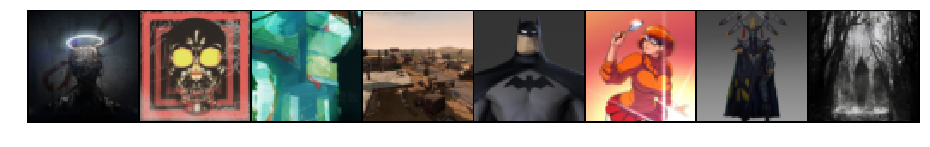

In [68]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                           transforms.Resize(image_size_art),
                           transforms.CenterCrop(image_size_art),
                           transforms.RandomHorizontalFlip(p=0.5),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

target_idx_dct = get_target_index(dataset)
total = 0
for k,v in target_idx_dct.items():
    print(f"Class {k} has {v['length']} entries.")
    total += v['length']
print(f"Total number of scraped images: {total}")

dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)

plot_images(dataloader, dataset.classes, image_number = 8)

In [20]:
# Create the Discriminator
netD = Discriminator_64(len(dataset.classes), ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

# Create the generator
netG = Generator_64(len(dataset.classes), ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Discriminator_64(
  (label_embedding): Embedding(5, 5)
  (convolution_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
  (linear_layers):

In [21]:
kwargs = {
    'dataloader': dataloader, # novel data dataloader
    'classes': dataset.classes, # novel dataset classes
    'save_dir':'capstone-novel-eval',
    'num_epochs': 0,
    'criterion': nn.BCELoss(), # Initialize BCELoss function
    'netD': netD,
    'netG': netG,
    'optimizerD': optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)),
    'optimizerG': optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999)),
    'device': device
}
    
cdcgan_novel = cDCGAN(**kwargs)

capstone-novel-eval directory exists.
capstone-novel-eval/checkpoints directory exists.
capstone-novel-eval/fake_images directory exists.


In [22]:
cdcgan_novel.load('capstone-model-novel-output/checkpoints/checkpoint_e100.pth.tar')

=> loading checkpoint: capstone-model-novel-output/checkpoints/checkpoint_e100.pth.tar
=> loaded checkpoint: capstone-model-novel-output/checkpoints/checkpoint_e100.pth.tar
Last epoch was 100


In [56]:
def generate_fake_images(model, class_index_tensor, noise, folder_name, image_name,
                         save = True, ncols = 8):

    '''
    Generate a batch of fake images using current generator weights.

    Inputs

        class_index_tensor (LongTensor)
            The class index to create fake images for. The number of fake images generated is equal
            to the length of the tensor. So a tensor filled with 10 "1"s will generate 10 images for
            the class that corresponds to "1".

        noise (Tensor)
            Random noise that will be put through the generator weights to produce an image.

        image_name (STR)
            Image name for the saved file.
            If running this function in model training, image_name should contain a changing variable,
            otherwise the files will just keep overwriting each other with the same name.
            Default: 'random' (in case save = True but no image_name provided)

        save (BOOL)
            If save is TRUE, the image file will be saved in the specified "self.fake_image_dir".
            Otherwise, just return the image data for plotting.
            Default: TRUE

    ''' 
    with torch.no_grad():
        # create fake images for a the labels in class_index_tensor
        fake = model.netG(noise, class_index_tensor).detach().cpu()

    if save: # save images in the fake_image_dir
        for i in range(len(fake.data)):
            save_image(fake.data[i], f'capstone-novel-eval/fake_images/{folder_name}/{image_name}_{i}.png', normalize=True)

    return 1


for i in range(len(dataset.classes)):
    print(f"Generating images for {dataset.classes[i]}")
    class_index_tensor = torch.LongTensor(100).fill_(i)
    noise = torch.randn(100, nz, device=device)
    generate_fake_images(cdcgan_novel, class_index_tensor, noise, 
                         folder_name = dataset.classes[i],
                         image_name = dataset.classes[i],
                         save = True)


cartoon
cyberpunk
horror
noir
western


Class cartoon has 100 entries.
Class cyberpunk has 100 entries.
Class horror has 100 entries.
Class noir has 100 entries.
Class western has 100 entries.
True labels:   noir     horror     cyberpunk     horror     western     western     cyberpunk      noir


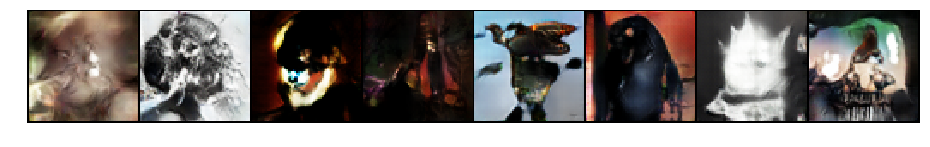

In [57]:
gen_dataset = dset.ImageFolder(root='capstone-novel-eval/fake_images',
                           transform=transforms.Compose([
                           transforms.Resize(image_size_art),
                           transforms.CenterCrop(image_size_art),
                           transforms.RandomHorizontalFlip(p=0.5),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

target_idx_dct = get_target_index(gen_dataset)
for k,v in target_idx_dct.items():
    print(f"Class {k} has {v['length']} entries.")

gen_dataloader = torch.utils.data.DataLoader(gen_dataset, batch_size = batch_size, shuffle = True)

plot_images(gen_dataloader, gen_dataset.classes, image_number = 8)

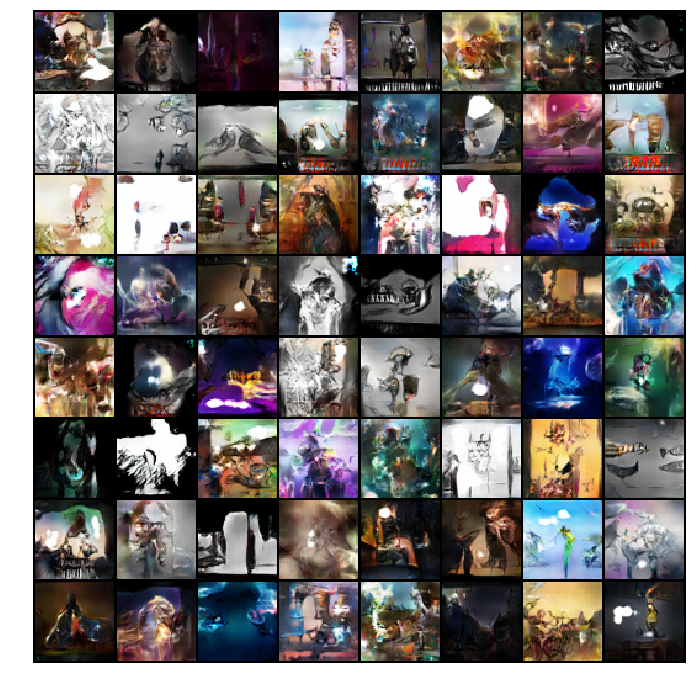

In [67]:
from torch.utils.data.sampler import SubsetRandomSampler

def plot_batch(dataloader):    
    '''
    Plot images from a dataloader
    '''
    batch = next(iter(dataloader))
    plt.figure(figsize=(20,12))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:100], padding=2, nrow=8, normalize=True).cpu(),(1,2,0)))

gen_dataloader = torch.utils.data.DataLoader(gen_dataset, batch_size = 64, 
                                         sampler = SubsetRandomSampler(target_idx_dct['noir']['indices']))

plot_batch(gen_dataloader)